In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

In [ ]:
def region_of_interest(img, vertices):
    # Define a blank matrix that matches the image height/width.
    mask = np.zeros_like(img)
    # Create a match color
    match_mask_color = 255

    # Fill inside the polygon
    cv2.fillPoly(mask, vertices, match_mask_color)

    # Returning the image only where mask pixels match
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    # If there are no lines to draw, exit.
    if lines is None:
            return
    # Make a copy of the original image.
    img = np.copy(img)
    # Create a blank image that matches the original in size.
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8,
    )
    # Loop over all lines and draw them on the blank image.
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    # Merge the image with the lines onto the original.
    img = cv2.addWeighted(img, 0.5, line_img, 1.0, 0.0)
    # Return the modified image.
    return img

def pipeline(image):
    """
    An image processing pipeline which will output
    an image with the lane lines annotated.
    """
    height = image.shape[0]
    width = image.shape[1]
    region_of_interest_vertices = [
        (0, height),
        (width / 2, height / 2),
        (width, height),
    ]
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    cannyed_image = cv2.Canny(gray_image, 100, 200)

    cropped_image = region_of_interest(
        cannyed_image,
        np.array(
            [region_of_interest_vertices],
            np.int32
        ),
    )

    lines = cv2.HoughLinesP(
        cropped_image,
        rho=6,
        theta=np.pi / 60,
        threshold=160,
        lines=np.array([]),
        minLineLength=40,
        maxLineGap=25
    )

    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            if math.fabs(slope) < 0.5:
                continue
            if slope <= 0:
                left_line_x.extend([x1, x2])
                left_line_y.extend([y1, y2])
            else:
                right_line_x.extend([x1, x2])
                right_line_y.extend([y1, y2])

    min_y = int(image.shape[0] * (3 / 5))
    max_y = int(image.shape[0])
    poly_left = np.poly1d(np.polyfit(
        left_line_y,
        left_line_x,
        deg=1
    ))

    left_x_start = int(poly_left(max_y))
    left_x_end = int(poly_left(min_y))

    poly_right = np.poly1d(np.polyfit(
        right_line_y,
        right_line_x,
       deg=1
    ))

    right_x_start = int(poly_right(max_y))
    right_x_end = int(poly_right(min_y))
    line_image = draw_lines(
        image,
        [[
            [left_x_start, max_y, left_x_end, min_y],
            [right_x_start, max_y, right_x_end, min_y],
        ]],
        thickness=5,
    )
    return line_image

This image is: <class 'numpy.ndarray'> with dimensions: (625, 1111, 3)


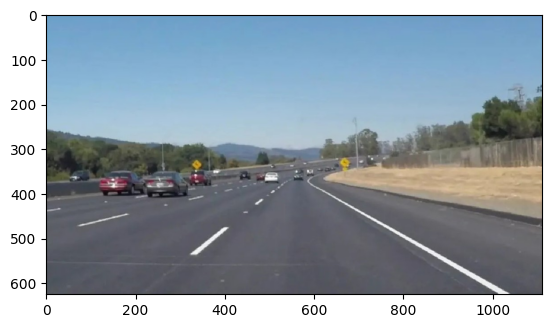

In [ ]:
# reading in an image
image = mpimg.imread('/content/solid.jpeg')
# printing out some stats and plotting the image
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)
plt.show()


In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'solidWhiteRight_output.mp4'
clip1 = VideoFileClip("solidWhiteRight_input.mp4")
white_clip = clip1.fl_image(pipeline)
white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video solidWhiteRight_output.mp4.
Moviepy - Writing video solidWhiteRight_output.mp4



Moviepy - Done !
Moviepy - video ready solidWhiteRight_output.mp4
